<a href="https://colab.research.google.com/github/stprior/explore-transformer/blob/main/attribution-gpt2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is a copy of attribution-gpt-neo-125 to compare results from gpt2 with gpt-neo.

# Setup


## Packages

In [1]:
%pip install transformer_utils
%pip install captum

     |████████████████████████████████| 2.6 MB 3.9 MB/s 
     |████████████████████████████████| 3.3 MB 33.3 MB/s 
     |████████████████████████████████| 895 kB 35.4 MB/s 
     |████████████████████████████████| 636 kB 44.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.4 MB 4.1 MB/s 


## Load Model

In [2]:
from transformer_utils.low_memory import enable_low_memory_load
import transformers

enable_low_memory_load()
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [3]:
import torch

def text_to_input_ids(text):
    toks = tokenizer.encode(text)
    return torch.as_tensor(toks).view(1, -1).cuda()

# Exploration


## Basics

In [4]:
text = "The forecast said that thunderstorm activity with the risk of hail will lead to localised"
tokens = text_to_input_ids(text)

(tensor([[  464, 11092,   531,   326, 18355, 12135,  3842,   351,   262,  2526,
            286, 32405,   481,  1085,   284,  1957,  1417]], device='cuda:0'),
 torch.Size([1, 17]),
 [' lead', ' to', ' local', 'ised'])

For each of the 17 positions, the Laguage Model makes a prediction of likelihood of each of the 50257 possible tokens being the next one. This graph shows an apparent trend, probably explained by earlier tokens being the more commonly used.

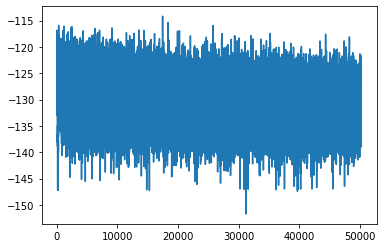

In [7]:
import matplotlib.pyplot as plt
plt.plot(result.logits[0,16].cpu().detach().numpy())

## Embedding Vectors

Bypassing language modelling so we can work directly with the transformer vectors, first confirm we get the same result:

In [9]:
embeds = model.transformer.wte(tokens)
transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
type(transformer_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [11]:
def show_prediction(transformer_outputs,posn):
  output_vec = transformer_outputs.last_hidden_state[0,posn]
  t_logits = model.lm_head(output_vec)
  t_predicted = torch.argmax(t_logits)
  print(t_predicted, tokenizer.decode(t_predicted), t_logits[t_predicted])

show_prediction(transformer_outputs,16)

tensor(17448, device='cuda:0')  flooding tensor(-114.1670, device='cuda:0', grad_fn=<SelectBackward>)


## Plot Embedding Vector Waveforms

This compares the embedding vector generated from the input token to that output by the top layer, predicting the next token.

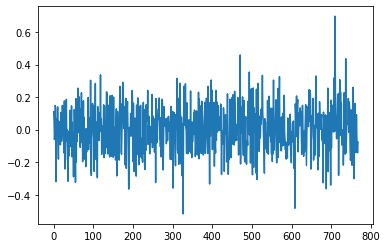

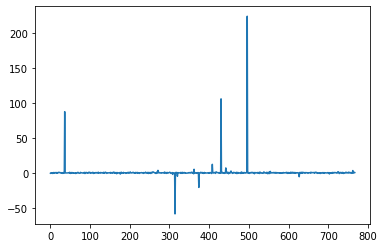

In [14]:
output_vec = transformer_outputs.last_hidden_state[0,16]
plt.plot(embeds[0,16].cpu().detach().numpy())
plt.show()
plt.plot(output_vec.cpu().detach().numpy())
plt.show()

# Attribution

## Attribute a specific logit output to embedding vector inputs

Now we can define a custom modified forward function which we can use for attribution for a specific output word vector. 
The model is wrapped in a function to allow transformer.forward be called with the inputs_embeds argument rather than default first arg, and to return the relevant logit as a single record 1d-tensor.

In [17]:

def make_forward_with_embeds(target_position, target_tokenid):
    
  def forward_with_embeds(embeds):
      
      transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
      output_vec = transformer_outputs.last_hidden_state[0,target_position]
      lm_logits = model.lm_head(output_vec)
      return lm_logits[target_tokenid:target_tokenid+1] #captum expects
    
  return forward_with_embeds

Test again (expect -114.1670)

In [18]:
make_forward_with_embeds( 16, 17448 )(embeds)

tensor([-114.1670], device='cuda:0', grad_fn=<SliceBackward>)

Using the [Integrated Gradients](https://arxiv.org/pdf/1703.01365.pdf) algorithm through [Captum](https://captum.ai/docs/extension/integrated_gradients) we use 
attribution to identify what part of the embedding inputs are most important to the logit for the expected output term (flooding).

In [19]:
from captum.attr import IntegratedGradients
def attribute(attributor):
  embeds = model.transformer.wte(tokens)
  embeds.requires_grad_()
  return attributor.attribute(embeds)

attr = attribute(IntegratedGradients(make_forward_with_embeds( 16, 17448 )))


### Input Position Salience

Using norm on each vector in the input and plotting against the corresponding label gives a plausible interpretation of the importance of each term.

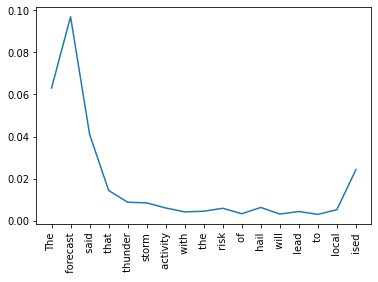

In [20]:
import numpy as np

def show_posn_salience(attribution):
  norms = np.linalg.norm(attribution.cpu().detach().numpy(), axis=1)
  labels = [tokenizer.decode(token) for token in tokens[0]]

  fig, ax = plt.subplots()
  ax.plot(norms)
  ax.set_xticks(np.arange(attribution.shape[0]))

  ax.set_xticklabels(labels,rotation='vertical')
  plt.show()

show_posn_salience(attr[0])

### Attribution to a single embedding vector
This shows attribution against the last token vector.

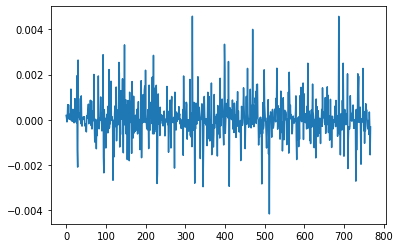

In [21]:
plt.plot(attr[0,16].cpu().detach().numpy())

## Attribute specific logit excess to embedding vector inputs

The previous wrapper of the forward method would identify inputs as significant even if they increased logits for other symbols more than the target one. The version below outputs the difference between the target logit and the mean of all logits. Further investigation is required to see if this is helpful or not.

In [22]:
def make_logit_less_mean_embeds(target_position, target_tokenid):
    
  def logit_less_mean_embeds(embeds):
      
      transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
      output_vec = transformer_outputs.last_hidden_state[0,target_position]
      lm_logits = model.lm_head(output_vec)
      logits_mean = torch.mean(lm_logits)
      return lm_logits[target_tokenid:target_tokenid+1] -logits_mean
    
  return logit_less_mean_embeds

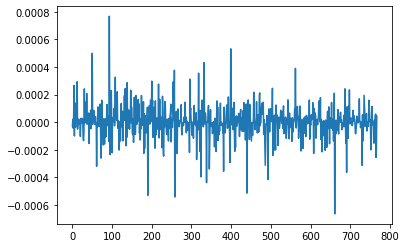

In [23]:

attr = attribute(IntegratedGradients(make_logit_less_mean_embeds( 16, 17448 )))

plt.plot(attr[0,16].cpu().detach().numpy())

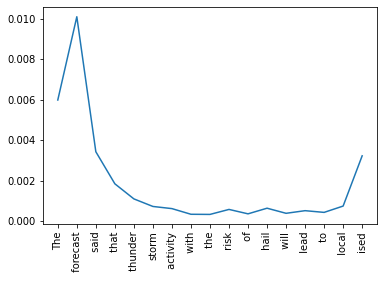

In [24]:

show_posn_salience(attr[0])

Results are similar but fewer positions are higlighted.

## Verify vector attribution

Attempt to verify that the attribution makes some sense, first by zeroing out the elements with the lowest attribution.

In [25]:
def drop_low_salience(level, abs_attrib=True, posn=16):
  embeds = model.transformer.wte(tokens)
  attr = ig.attribute(embeds)
  attribv = torch.abs(attr[0,posn]) if abs_attrib else attr[0,posn]
  mask = attribv.ge(level)
  drop_masked(embeds, mask)

def drop_masked(embeds, mask, posn=16):
  embeds = model.transformer.wte(tokens)
  original = torch.clone(embeds[0,posn])
  fake = torch.where(mask, original,torch.zeros_like(original))
  embeds[0,posn]=fake
  transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
  output_vec = transformer_outputs.last_hidden_state[0,posn]
  t_logits = model.lm_head(output_vec)
  t_predicted = torch.argmax(t_logits)
  print(f'Kept {torch.count_nonzero(fake)} of {torch.count_nonzero(original)} nonzero elements')

  transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
  output_vec = transformer_outputs.last_hidden_state[0,posn]
  t_logits = model.lm_head(output_vec)
  t_predicted = torch.argmax(t_logits)
  print(f'Predicted token {t_predicted} "{tokenizer.decode(t_predicted)}" logit value: {t_logits[t_predicted]}')



### Drop Low Salience Elements

In [29]:
ig = IntegratedGradients(make_logit_less_mean_embeds( 16, 17448 ))
drop_low_salience(0.0003)
drop_low_salience(0.0002)
drop_low_salience(0.00015)
drop_low_salience(0.0001)



Kept 22 of 768 nonzero elements
Predicted token 18355 " thunder" logit value: -94.4098892211914
Kept 63 of 768 nonzero elements
Predicted token 1417 "ised" logit value: -96.73153686523438
Kept 108 of 768 nonzero elements
Predicted token 18355 " thunder" logit value: -109.29541778564453
Kept 190 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -117.55022430419922


In [31]:
ig = IntegratedGradients(make_forward_with_embeds( 16, 17448 ))

drop_low_salience(0.003)
drop_low_salience(0.002)
drop_low_salience(0.0015)
drop_low_salience(0.001)


Kept 6 of 768 nonzero elements
Predicted token 32405 " hail" logit value: -90.62446594238281
Kept 37 of 768 nonzero elements
Predicted token 6279 " cloud" logit value: -87.8970718383789
Kept 74 of 768 nonzero elements
Predicted token 1417 "ised" logit value: -80.52691650390625
Kept 138 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -115.29566192626953


### Drop Random Elements

Compare this to randomly dropping a similar number of elements

In [33]:
def drop_random(rate):
  embeds = model.transformer.wte(tokens)
  mask = torch.rand(embeds[0,0].shape, device=embeds.device).ge(rate) 
  drop_masked(embeds, mask)

drop_random(762/768)
drop_random(731/768)
drop_random(690/768)
drop_random(630/768)
drop_random(100/768)



Kept 7 of 768 nonzero elements
Predicted token 18355 " thunder" logit value: -92.91481018066406
Kept 38 of 768 nonzero elements
Predicted token 20228 " storms" logit value: -94.1800537109375
Kept 67 of 768 nonzero elements
Predicted token 32405 " hail" logit value: -92.04132843017578
Kept 141 of 768 nonzero elements
Predicted token 18355 " thunder" logit value: -98.49168395996094
Kept 673 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -116.01563262939453


###Drop Highly Salient Elements

Inverting this, how many high salience tokens do we need to drop to affect the predicted token.

In [37]:
def drop_high_salience(level, abs_attrib=True):
  embeds = model.transformer.wte(tokens)
  attr = ig.attribute(embeds)
  attribv = torch.abs(attr[0,16]) if abs_attrib else attr[0,16]
  mask = attribv.le(level)
  drop_masked(embeds, mask)

drop_high_salience(0.004)
drop_high_salience(0.001)
drop_high_salience(0.0005)
drop_high_salience(0.0002)

Kept 764 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -114.20236206054688
Kept 630 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -118.7251205444336
Kept 497 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -114.12141418457031
Kept 296 of 768 nonzero elements
Predicted token 871 "ities" logit value: -102.48456573486328


### Result 

GPT2 appears much less sensitive to individual neuron changes, both in terms of most and least salient for a particular output and random.


Checking a different position

In [38]:
print(tokens[0,13], tokenizer.decode(tokens[0,13]))
print(tokens[0,14], tokenizer.decode(tokens[0,14]))
print(tokens[0,15], tokenizer.decode(tokens[0,15]))
print(tokens[0,16], tokenizer.decode(tokens[0,16]))

tensor(1085, device='cuda:0')  lead
tensor(284, device='cuda:0')  to
tensor(1957, device='cuda:0')  local
tensor(1417, device='cuda:0') ised


In [39]:
embeds = model.transformer.wte(tokens)
transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
show_prediction(transformer_outputs,13)
show_prediction(transformer_outputs,14)
show_prediction(transformer_outputs,15)
show_prediction(transformer_outputs,16)

tensor(284, device='cuda:0')  to tensor(-49.4169, device='cuda:0', grad_fn=<SelectBackward>)
tensor(257, device='cuda:0')  a tensor(-104.9720, device='cuda:0', grad_fn=<SelectBackward>)
tensor(17448, device='cuda:0')  flooding tensor(-105.7585, device='cuda:0', grad_fn=<SelectBackward>)
tensor(17448, device='cuda:0')  flooding tensor(-114.1670, device='cuda:0', grad_fn=<SelectBackward>)


First look at input 'lead' predicting token 'to'.
In contrast to gpt-neo-125 this shows greater dependency on previous token.

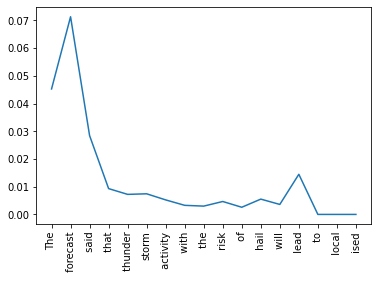

In [40]:
attr = attribute(IntegratedGradients(make_forward_with_embeds(13,284)))
show_posn_salience(attr[0])

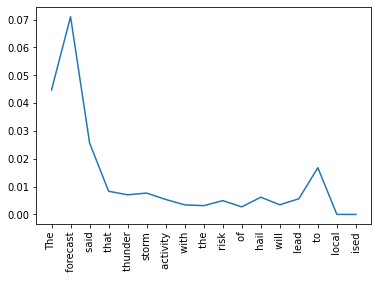

In [41]:
attr = attribute(IntegratedGradients(make_forward_with_embeds(14,1957)))
show_posn_salience(attr[0])

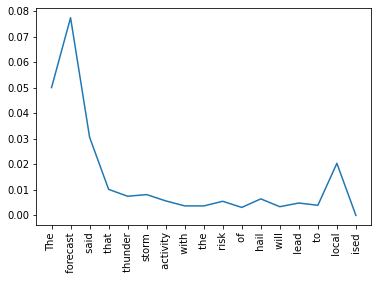

In [42]:
attr = attribute(IntegratedGradients(make_forward_with_embeds(15,1417)))
show_posn_salience(attr[0])

GPT2 appears much more dependent on previous token compared to gpt-neo-125